#Football Player Prediction

In [106]:
#Standard-Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Modellierung
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.impute import SimpleImputer
import joblib

In [107]:
# CSV-Dateien laden
wyscout_df = pd.read_csv("wyscout_players_final.csv")
kaggle_df = pd.read_csv("kaggle_player_stats.csv")
nonpro_df = pd.read_csv("youth_players_final.csv")

# Zieldefinition:
wyscout_df["is_pro"] = 1


# Kombinieren
combined_df = pd.concat([kaggle_df, wyscout_df, nonpro_df], ignore_index=True)

combined_df.head()

,name,minutes_played,goals,assists,passes_total,passes_success,shots_total,shots_on_target,duels_total,duels_won,ball_losses,recoveries,is_pro,activity_score
0,Alessandro Russo,29.0,NaN,NaN,20.0,13.3,NaN,0.00,0.00,0.00,NaN,10.00,0,23.30
1,Luis Hernández,1366.0,NaN,NaN,51.4,40.9,NaN,0.07,0.53,0.39,NaN,8.68,1,49.97
2,Yvandro Borges Sanches,28.0,NaN,NaN,30.0,26.7,NaN,0.00,6.67,6.67,NaN,10.00,1,43.37
3,Gori,9.0,NaN,NaN,50.0,40.0,NaN,0.00,0.00,0.00,NaN,0.00,1,40.00
4,Kristijan Jaki?,1879.0,NaN,NaN,40.4,30.4,NaN,0.33,2.25,1.39,NaN,12.80,1,44.59


In [108]:
combined_df["is_pro"].value_counts()


is_pro
0    2869
1    2845
Name: count, dtype: int64

In [109]:
# Feature: Passquote
combined_df["pass_accuracy"] = (
    combined_df["passes_success"] / combined_df["passes_total"]
).round(2)

In [110]:
# Feature: Gesamteffektivität
combined_df["pass_accuracy"] = (
    combined_df["passes_success"] / combined_df["passes_total"].replace(0, np.nan)
).round(2)


combined_df["activity_score"] = (
    combined_df["passes_success"].fillna(0) +
    combined_df["duels_won"].fillna(0) +
    combined_df["recoveries"].fillna(0)
).round(2)

combined_df.head()

,name,minutes_played,goals,assists,passes_total,passes_success,shots_total,shots_on_target,duels_total,duels_won,ball_losses,recoveries,is_pro,activity_score,pass_accuracy
0,Alessandro Russo,29.0,NaN,NaN,20.0,13.3,NaN,0.00,0.00,0.00,NaN,10.00,0,23.30,0.66
1,Luis Hernández,1366.0,NaN,NaN,51.4,40.9,NaN,0.07,0.53,0.39,NaN,8.68,1,49.97,0.80
2,Yvandro Borges Sanches,28.0,NaN,NaN,30.0,26.7,NaN,0.00,6.67,6.67,NaN,10.00,1,43.37,0.89
3,Gori,9.0,NaN,NaN,50.0,40.0,NaN,0.00,0.00,0.00,NaN,0.00,1,40.00,0.80
4,Kristijan Jaki?,1879.0,NaN,NaN,40.4,30.4,NaN,0.33,2.25,1.39,NaN,12.80,1,44.59,0.75


In [111]:
#Datenüberblick
combined_df.info()
combined_df.describe()
combined_df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5714 entries, 0 to 5713
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             5714 non-null   object 
 1   minutes_played   5714 non-null   float64
 2   goals            102 non-null    float64
 3   assists          102 non-null    float64
 4   passes_total     5714 non-null   float64
 5   passes_success   5714 non-null   float64
 6   shots_total      102 non-null    float64
 7   shots_on_target  5712 non-null   float64
 8   duels_total      5712 non-null   float64
 9   duels_won        5712 non-null   float64
 10  ball_losses      102 non-null    float64
 11  recoveries       5712 non-null   float64
 12  is_pro           5714 non-null   int64  
 13  activity_score   5714 non-null   float64
 14  pass_accuracy    5679 non-null   float64
dtypes: float64(13), int64(1), object(1)
memory usage: 669.7+ KB


name                  0
minutes_played        0
goals              5612
assists            5612
passes_total          0
passes_success        0
shots_total        5612
shots_on_target       2
duels_total           2
duels_won             2
ball_losses        5612
recoveries            2
is_pro                0
activity_score        0
pass_accuracy        35
dtype: int64

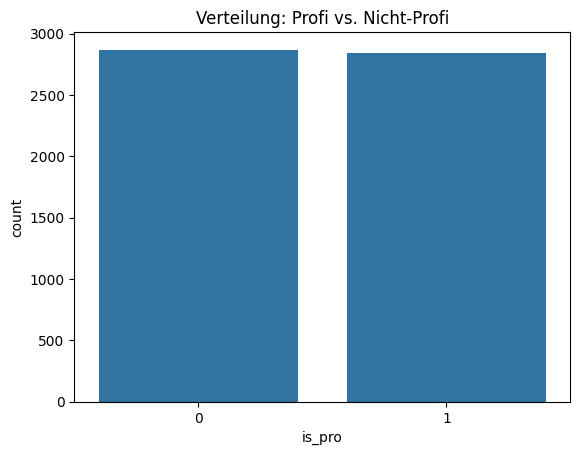

In [112]:
combined_df["is_pro"].value_counts(normalize=True)
sns.countplot(data=combined_df, x="is_pro")
plt.title("Verteilung: Profi vs. Nicht-Profi")
plt.show()


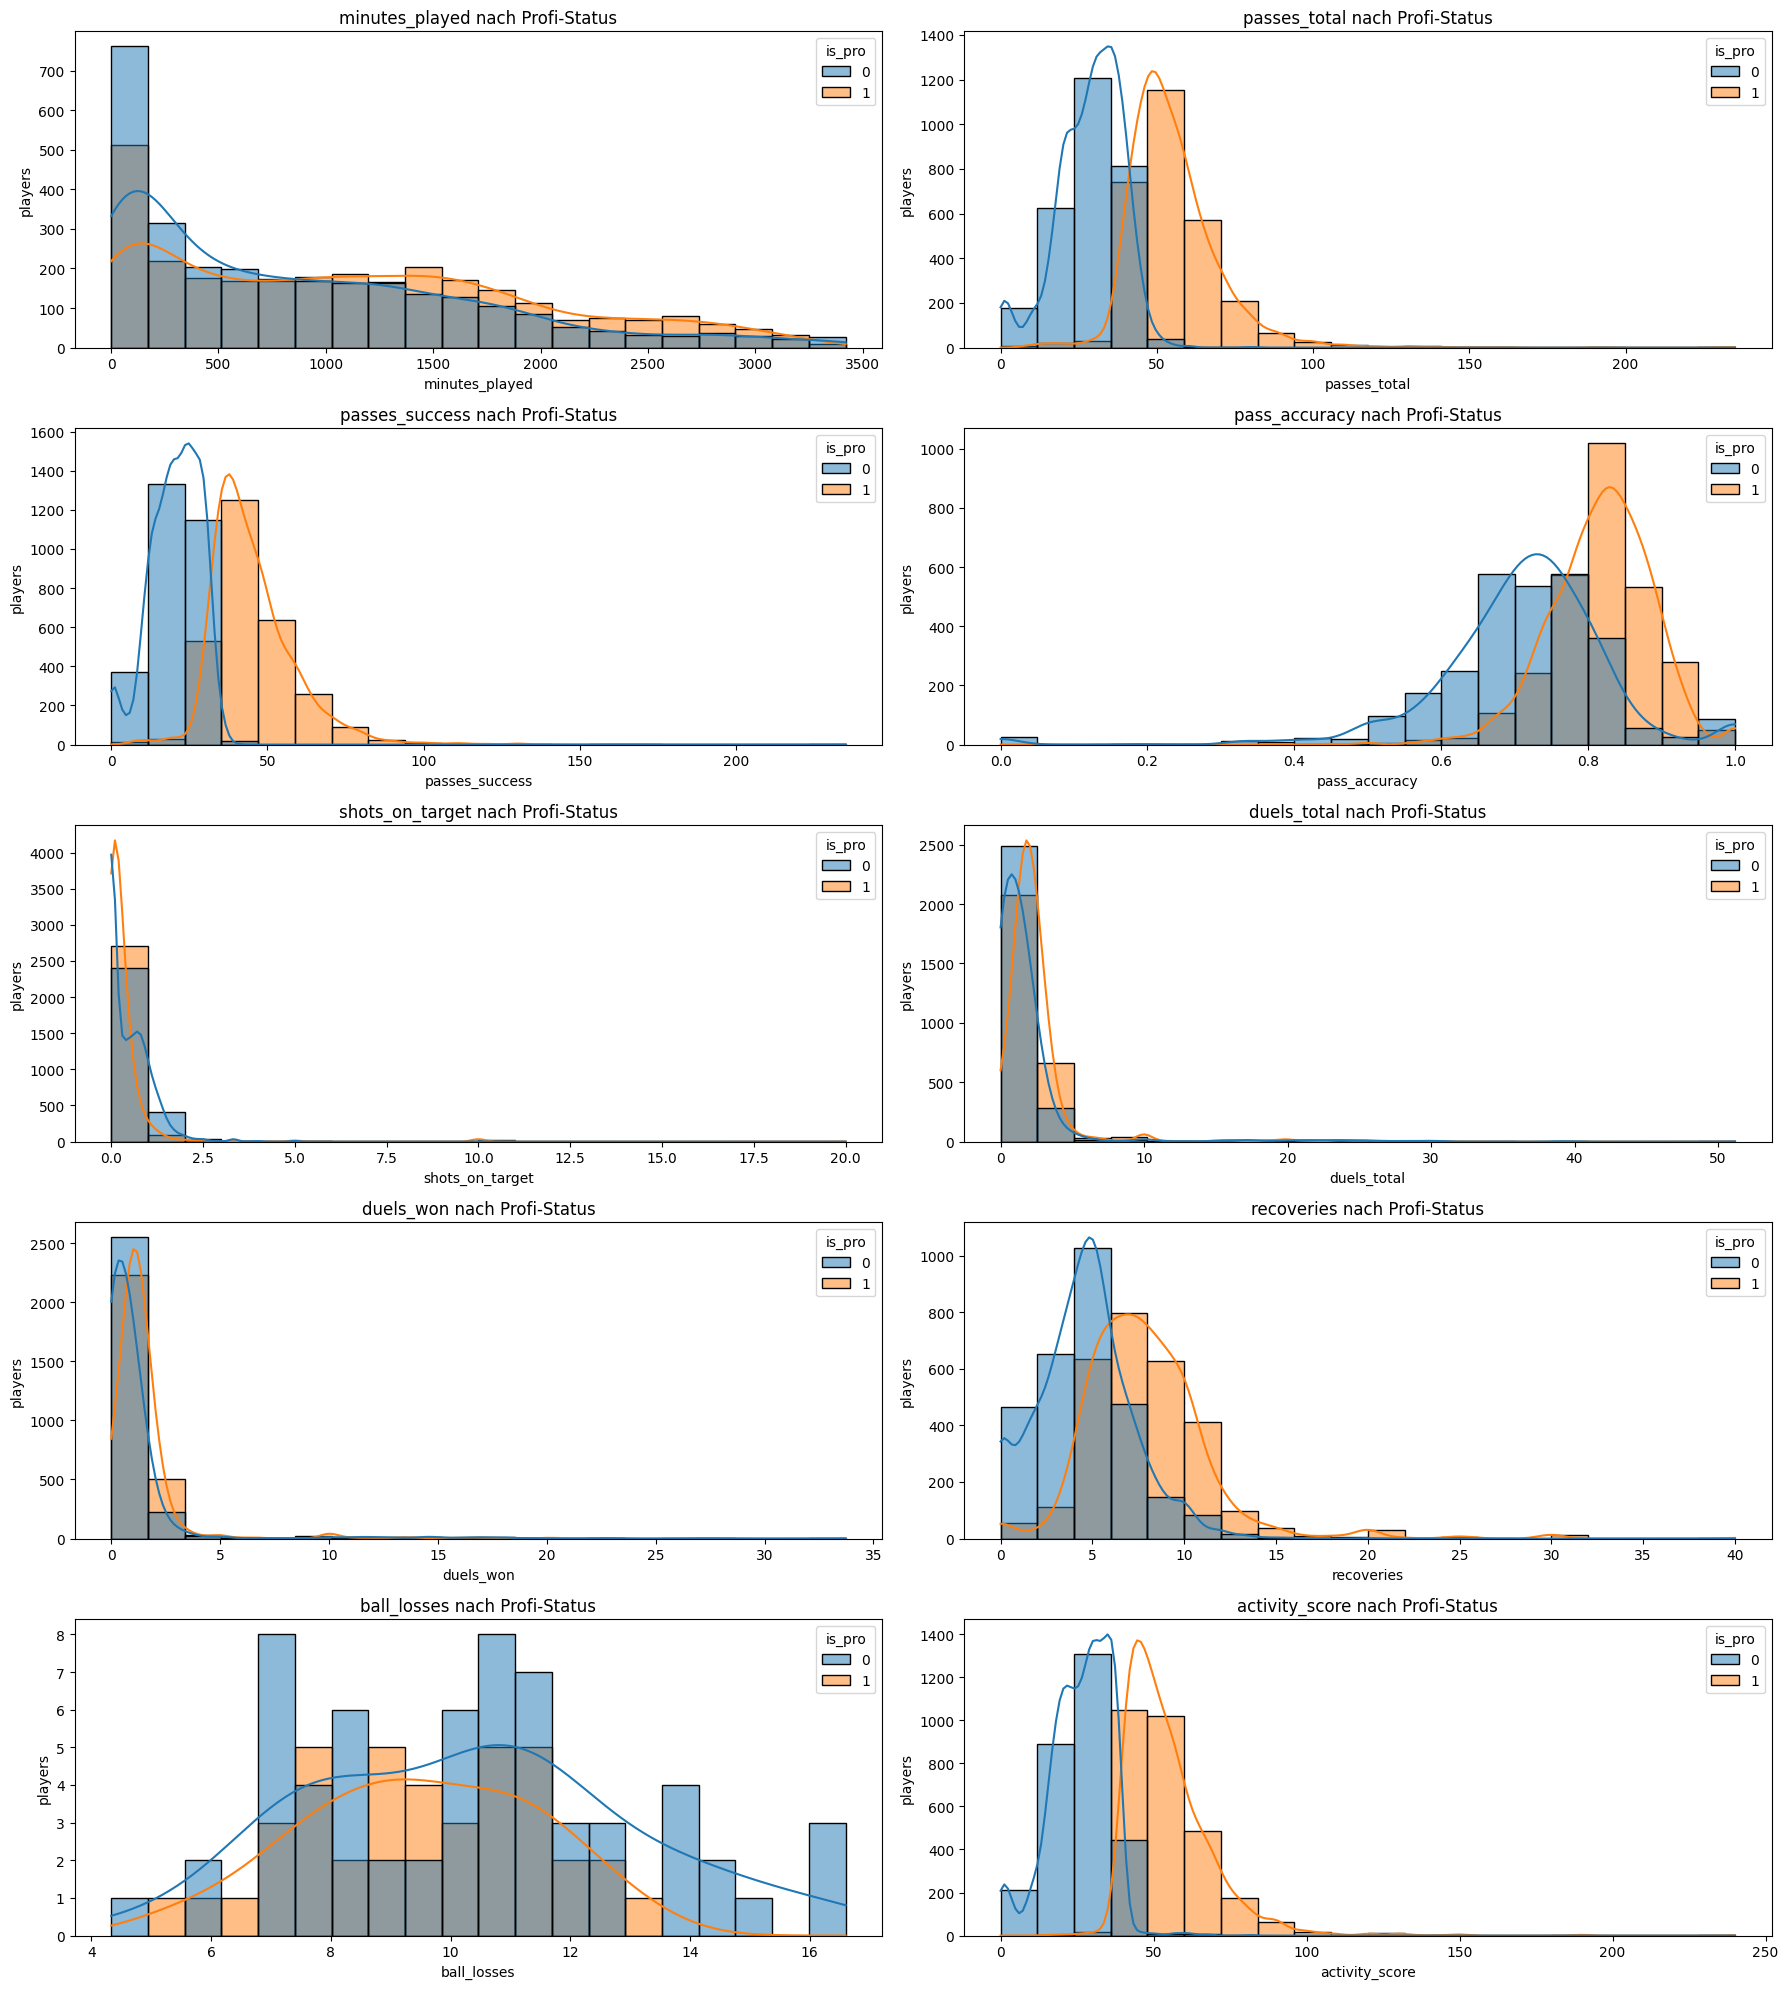

In [113]:
features = [
    "minutes_played",
    "passes_total",
    "passes_success",
    "pass_accuracy",
    "shots_on_target",
    "duels_total",
    "duels_won",
    "recoveries",
    "ball_losses",
    "activity_score"
]

# Zeichne alle Histogramme in einem Raster (z. B. 5x2)
plt.figure(figsize=(18, 20))
for i, feature in enumerate(features):
    plt.subplot(5, 2, i + 1)
    sns.histplot(data=combined_df, x=feature, hue="is_pro", kde=True, bins=20)
    plt.title(f"{feature} nach Profi-Status")
    plt.xlabel(feature)
    plt.ylabel("players")

plt.tight_layout()
plt.show()

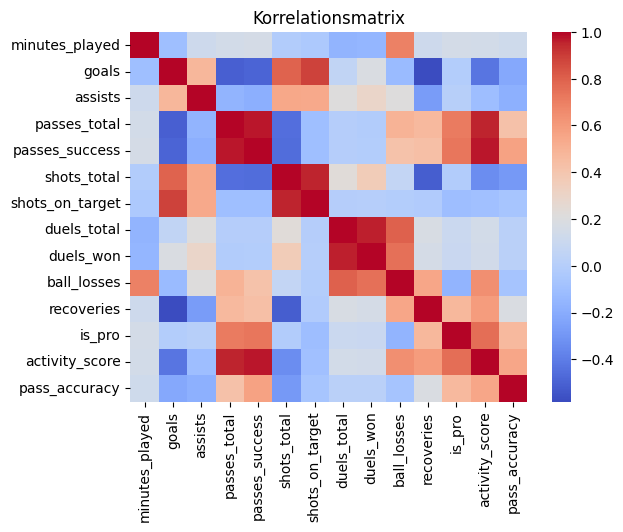

In [114]:
#Korrelationen analysieren

sns.heatmap(combined_df.corr(numeric_only=True), cmap="coolwarm")
plt.title("Korrelationsmatrix")
plt.show()

In [115]:
# Entferne unrealistische Werte (z. B. extreme Pässe pro 90')
combined_df = combined_df[combined_df["passes_total"] <= 120]
combined_df = combined_df[combined_df["duels_total"] <= 60]

# Vorschau nach dem Filtern
combined_df.reset_index(drop=True, inplace=True)
combined_df.head()

,name,minutes_played,goals,assists,passes_total,passes_success,shots_total,shots_on_target,duels_total,duels_won,ball_losses,recoveries,is_pro,activity_score,pass_accuracy
0,Alessandro Russo,29.0,NaN,NaN,20.0,13.3,NaN,0.00,0.00,0.00,NaN,10.00,0,23.30,0.66
1,Luis Hernández,1366.0,NaN,NaN,51.4,40.9,NaN,0.07,0.53,0.39,NaN,8.68,1,49.97,0.80
2,Yvandro Borges Sanches,28.0,NaN,NaN,30.0,26.7,NaN,0.00,6.67,6.67,NaN,10.00,1,43.37,0.89
3,Gori,9.0,NaN,NaN,50.0,40.0,NaN,0.00,0.00,0.00,NaN,0.00,1,40.00,0.80
4,Kristijan Jaki?,1879.0,NaN,NaN,40.4,30.4,NaN,0.33,2.25,1.39,NaN,12.80,1,44.59,0.75


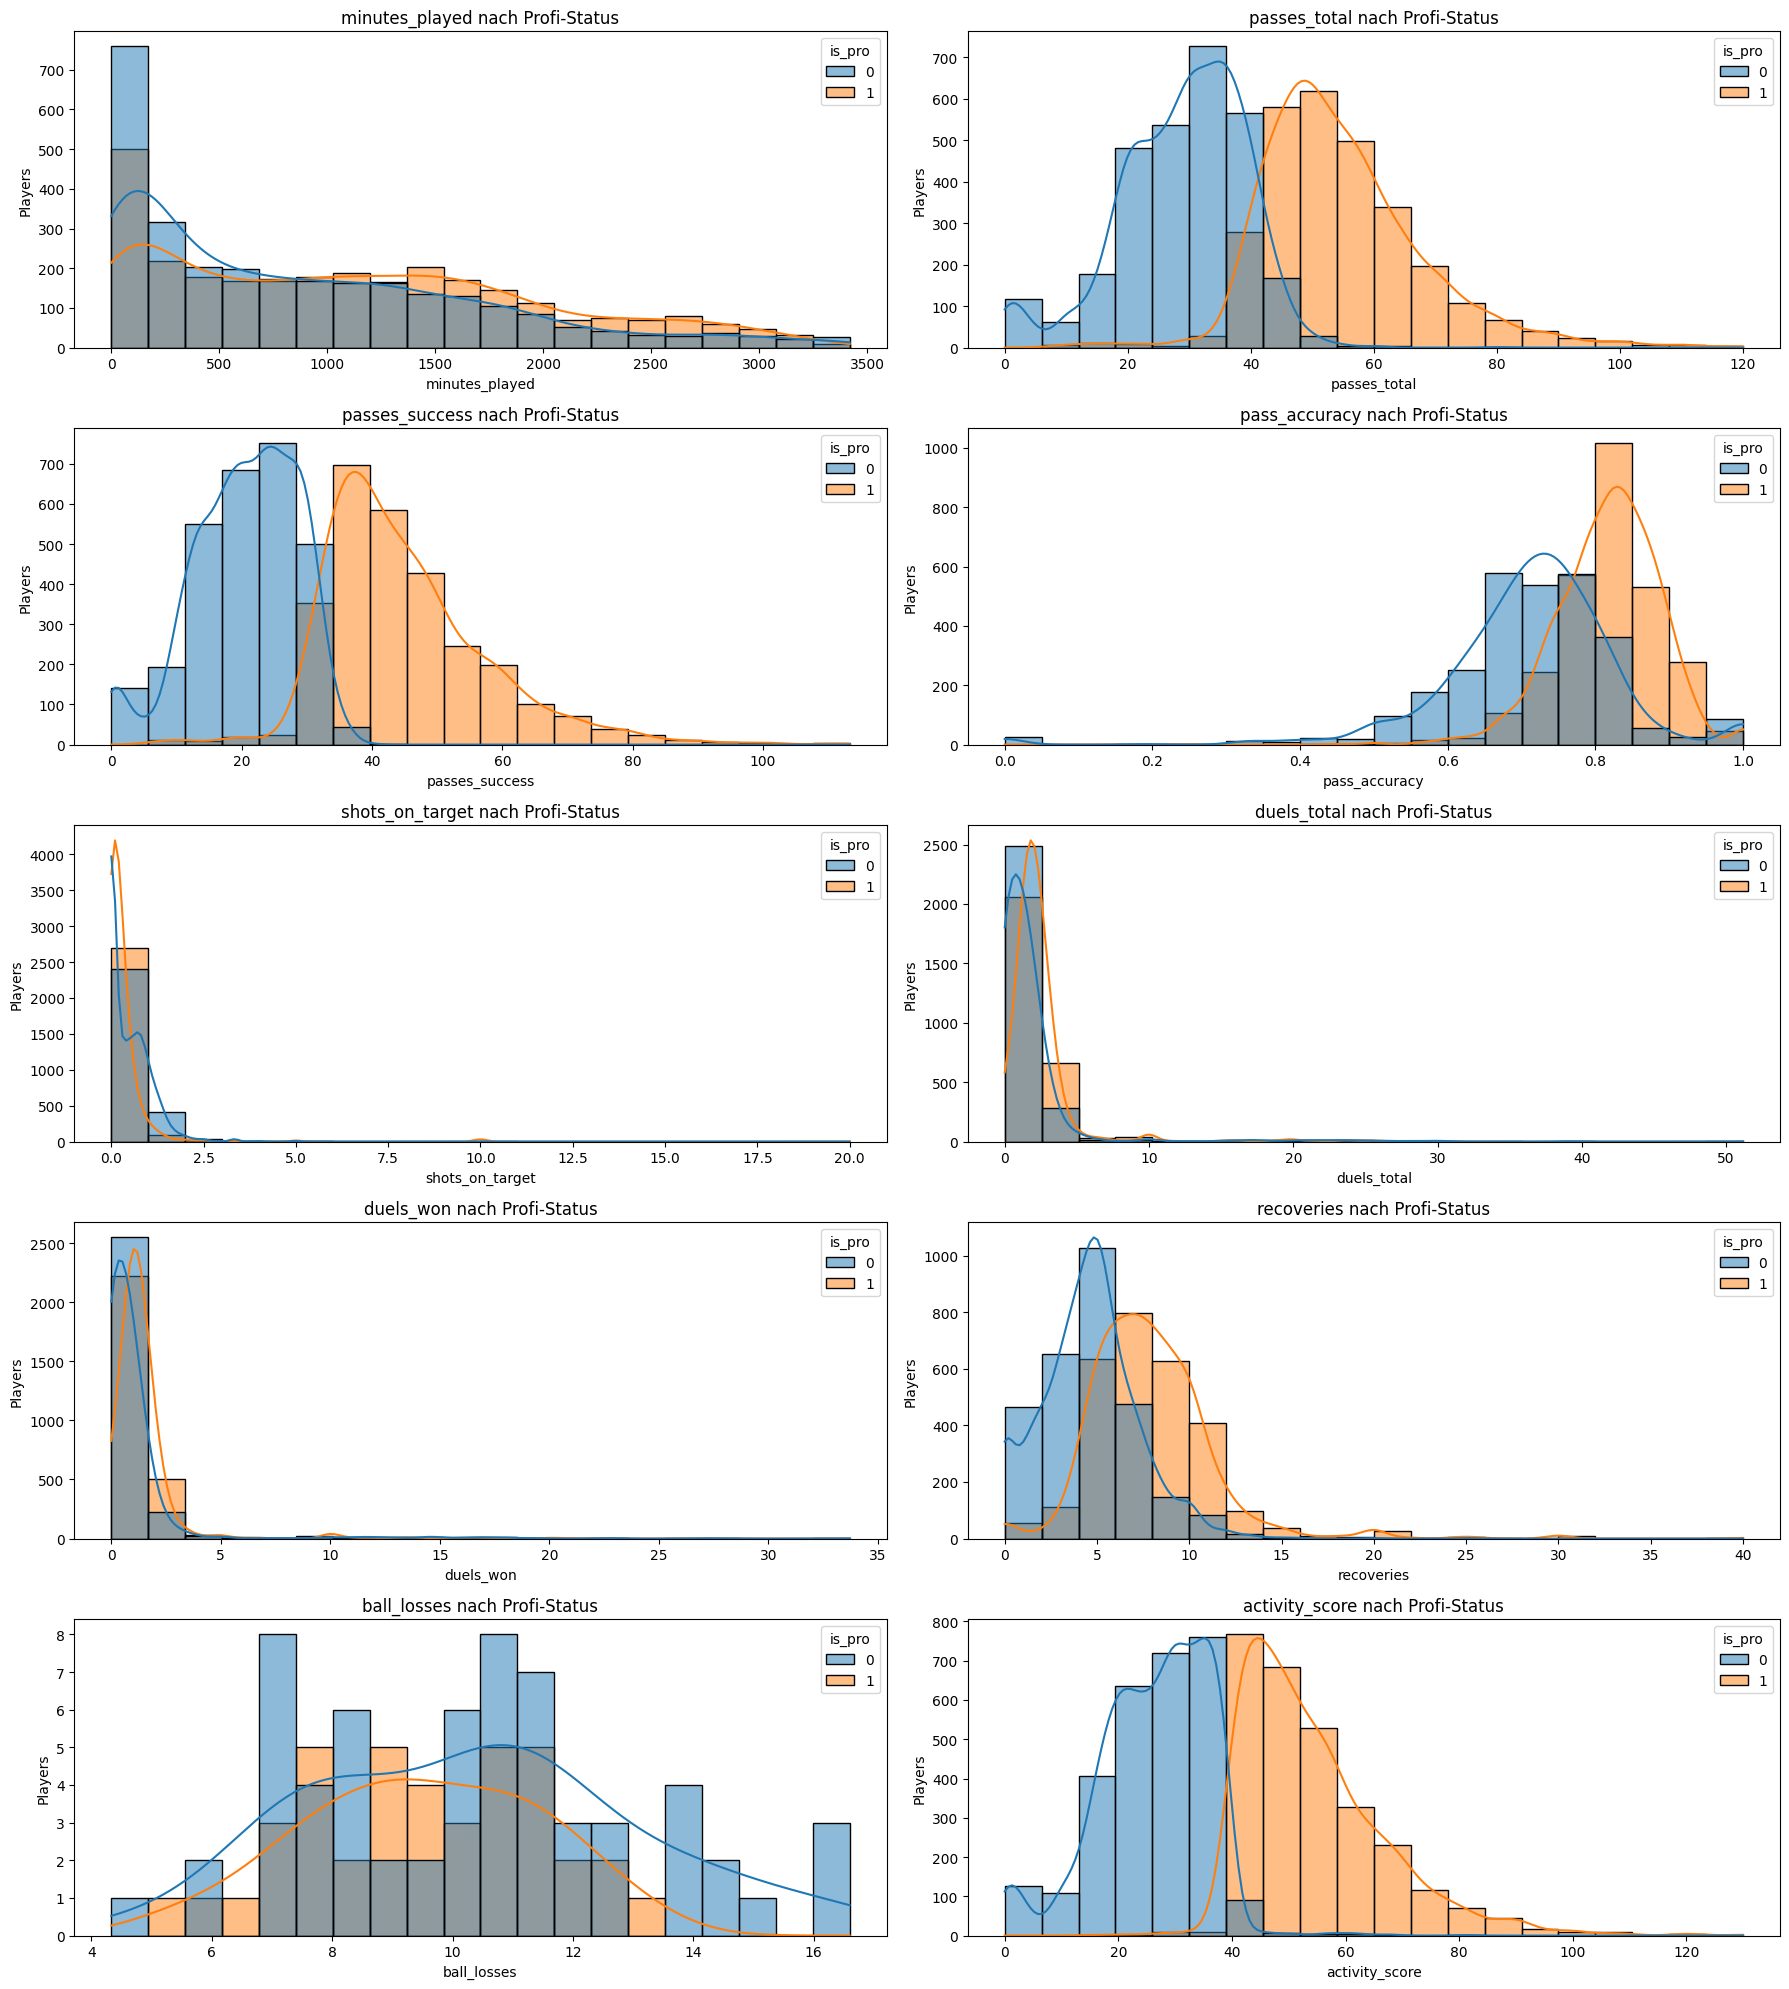

In [116]:
#Visualisierung nach Bereinigung
features = [
    "minutes_played",
    "passes_total",
    "passes_success",
    "pass_accuracy",
    "shots_on_target",
    "duels_total",
    "duels_won",
    "recoveries",
    "ball_losses",
    "activity_score"
]

plt.figure(figsize=(18, 20))
for i, feature in enumerate(features):
    if combined_df[feature].dropna().nunique() <= 1:
        print(f"⚠️  Überspringe {feature} – hat zu wenig gültige Werte.")
        continue
    plt.subplot(5, 2, i + 1)
    sns.histplot(data=combined_df, x=feature, hue="is_pro", kde=True, bins=20)
    plt.title(f"{feature} nach Profi-Status")
    plt.xlabel(feature)
    plt.ylabel("Players")

plt.tight_layout()
plt.show()


In [117]:
# Feature-Auswahl
features_for_model = [
    "minutes_played",
    "passes_total",
    "passes_success",
    "pass_accuracy",
    "shots_on_target",
    "duels_total",
    "duels_won",
    "recoveries",
    "ball_losses",
    "activity_score"
]

X = combined_df[features_for_model]
y = combined_df["is_pro"]


In [118]:
#Train/Test-Split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [119]:
imputer = SimpleImputer(strategy="mean")
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

In [120]:
# Modell 1: Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)


In [121]:
# Modell 2: Logistic Regression
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)
lr_preds = lr_model.predict(X_test)


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [122]:
# Evaluation Random Forest
print("🔍 Random Forest:")
print("Accuracy:", accuracy_score(y_test, rf_preds))
print("Confusion Matrix:\n", confusion_matrix(y_test, rf_preds))
print("Classification Report:\n", classification_report(y_test, rf_preds))

🔍 Random Forest:
Accuracy: 0.9903508771929824
Confusion Matrix:
 [[567   6]
 [  5 562]]
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       573
           1       0.99      0.99      0.99       567

    accuracy                           0.99      1140
   macro avg       0.99      0.99      0.99      1140
weighted avg       0.99      0.99      0.99      1140



In [123]:
# Evaluation Logistic Regression
print("\n🔍 Logistic Regression:")
print("Accuracy:", accuracy_score(y_test, lr_preds))
print("Confusion Matrix:\n", confusion_matrix(y_test, lr_preds))
print("Classification Report:\n", classification_report(y_test, lr_preds))


🔍 Logistic Regression:
Accuracy: 0.9824561403508771
Confusion Matrix:
 [[558  15]
 [  5 562]]
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.97      0.98       573
           1       0.97      0.99      0.98       567

    accuracy                           0.98      1140
   macro avg       0.98      0.98      0.98      1140
weighted avg       0.98      0.98      0.98      1140



In [124]:
# Vergleiche Accuracy der beiden Modelle
rf_acc = accuracy_score(y_test, rf_preds)
lr_acc = accuracy_score(y_test, lr_preds)

print("\n📊 Vergleich der Modellgenauigkeit:")
print(f"Random Forest Accuracy:        {rf_acc:.4f}")
print(f"Logistic Regression Accuracy:  {lr_acc:.4f}")

# Wähle das bessere Modell
if rf_acc > lr_acc:
    best_model = rf_model
    model_name = "Random Forest"
else:
    best_model = lr_model
    model_name = "Logistic Regression"


📊 Vergleich der Modellgenauigkeit:
Random Forest Accuracy:        0.9904
Logistic Regression Accuracy:  0.9825


In [126]:
train_preds = best_model.predict(X_train)
test_preds = best_model.predict(X_test)

train_acc = accuracy_score(y_train, train_preds)
test_acc = accuracy_score(y_test, test_preds)

print(f"Train Accuracy: {train_acc:.4f}")
print(f"Test Accuracy:  {test_acc:.4f}")

Train Accuracy: 1.0000
Test Accuracy:  0.9904


In [125]:
joblib.dump(rf_model, "pro_player_model.pkl")

['pro_player_model.pkl']